In [5]:
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install torch==1.9.0 fastcore==1.3.20 pytorch_inferno==0.2.2')

# A PyTorch Drop-In Implementation of The INFERNO Algorithm
## Giles Strong
## PyHEP 2021, Online 06/07/21

### [GitHub](https://github.com/GilesStrong/pytorch_inferno) [Docs](https://gilesstrong.github.io/pytorch_inferno/)

# Traditional signal-versus-background classifier

- Common approach in HEP searches: train binary classifier for signal and background(s)
    - Loss is binary cross-entropy
    - Systematic uncertainties (nuisance parameters) ignored during training
- Resulting classification score binned and used as summary statistic for inference of the signal strength (parameter of interest, PoI)
    - Only now are systematic uncertainties considered
    - If effects are large, BCE training is no longer optimal & performance is sub-optimal
    
<img src="imgs/bce_result.png" width="1500">

# The INFERNO algorithm

- [de Castro & Dorigo 2018](https://www.sciencedirect.com/science/article/pii/S0010465519301948)
- Systematic uncertainties included during training
    - Directly optimise deep neural network (DNN) for statistical inference of the PoI
    - Loss is the PoI element of the inverse Hessian of the log-likelihood w.r.t. PoI and nuisance parameters
    - Encouraged to have steep gradient w.r.t. PoI and shallow gradient w.r.t. nuisances
- DNN output is a pre-binned summary statistic
    - Softmax output, but can hard-assign after training
    - "Classes" are unordered and emerge as a function of the training
    - Learned binning allows INFERNO to account for nuisances on both input features & normalisation
- Further discussion in blog posts ([part 1 of 5](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/04/inferno-1.html))

<img src="imgs/inferno_result.png" width="1500">

# INFERNO implementation
## General implementation

1. Specify how nusiances would modify input features to DNN - makes DNN out differentiable w.r.t. nuisnaces
1. Pass data through DNN
1. Compute signal & bkg. shapes and normalise by rates
1. Compute profile log-likelihood (NLL) at Asimov count (sig+bkg and no nuisances)
1. Compute hessian of NLL w.r.t nuisances and PoI
1. Loss is the PoI element of the inverted hessian $\nabla^2 NLL ^{-1}_{\mathrm{PoI,PoI}}$
1. Back-propagate loss and update DNN parameters

## Difficulties

- Data needs to be modified before forwards pass to include the effect of the nuisances
- May need to reevaluate model response on data without the nuisances to get Asimov predictions

# INFERNO as a drop-in* loss

- Main aim: implement INFERNO such that
    - it doesn't require a specific, hard-coded training loop
    - it can easily be interchanged with other loss functions, to compare performance
- Implement loss as a *callback* class
    - Has access to DNN and data
    - Can perform actions at required points during optimisation cycle

# The PyTorch INFERNO package

- Provides DNN training wrapper for PyTorch, with extensive callback system
- Basic inference system for NLL minimisation with nuisances
- Abstract class implementation of INFERNO
    - User can inherit and fine-tune it for their specific use-case
- Also includes an experimental approximation of INFERNO for use with up/down systematic MC datasets used in HEP
    - User doesn't need to analytically describe how the input features depend on the nuisances
    - Instead, nuisance effects extracted from interpolation between systematic and nominal datasets
- Package successfully reproduces paper results on toy dataset

# Optimisation loop

`ModelWrapper` class provides training of DNNs (`self.model`).

Callbacks are attributes of the `ModelWrapper`, and each callback has the `ModelWrapper` as an attribute.

The INFERNO callback can therefore alter the data (`self.x`) before the forwards pass, and compute the loss before the backwards pass.

This is the forwards pass for a batch of data. 

```python
def _fit_batch(self, x:Tensor, y:Tensor, w:Tensor) -> None:
    self.x,self.y = to_device(x,self.device),to_device(y,self.device)
    for c in self.cbs: c.on_batch_begin()  # <-- INFERNO callback modifes data
    self.y_pred = self.model(self.x)
    if self.state != 'test' and self.loss_func is not None:
        self.loss_val = self.loss_func(self.y_pred, self.y)
    for c in self.cbs: c.on_forwards_end()  # <-- INFERNO callback manually sets the loss value
```

# Data modification

When a new batch of data is loaded, the `AbsInferno` class runs:
```python
def on_batch_begin(self) -> None:
        self.b_mask = self.wrapper.y.squeeze() == 0
        self._aug_data(self.wrapper.x)
```
The user overrides `_aug_data` to provide an appropriate modification of the input features, e.g.:
```python
def _aug_data(self, x:Tensor) -> None:
        x[self.b_mask,0] +=  self.alpha[self.shape_idxs[0]]  # Nuisance shifts input 0 
        x[self.b_mask,2] *= (self.alpha[self.shape_idxs[-1]]+3)/3  # Nuisance rescales input 2
```     
Where `self.alpha` is a tensor of zeros i.e. the nuisance parameters at their nominal values.

# Loss computation

After forwards pass, INFERNO computes prediction shapes and reruns DNN predictions on unmodified data.

Only shape nuisances included so far.

`self.get_inv_ikk` computes the loss.

```python
def on_forwards_end(self) -> None:
    # Shapes with derivatives w.r.t. nuisances
    f_s = self.to_shape(self.wrapper.y_pred[~self.b_mask], w_s)
    f_b = self.to_shape(self.wrapper.y_pred[self.b_mask], w_b)
    # Shapes without derivatives w.r.t. nuisances
    f_s_asimov = self.to_shape(self.wrapper.model(self.wrapper.x[~self.b_mask].detach()), w_s)
    f_b_asimov = self.to_shape(self.wrapper.model(self.wrapper.x[self.b_mask].detach()), w_b)
    self.wrapper.loss_val = self.get_inv_ikk(f_s, f_b, f_s_asimov, f_b_asimov)
```        

# Loss computation

Expected counts for signal & bkg modified by rate nuisances and PoI.

NLL computed at nominal PoI. Can also constrain NLL using auxiliary measurements.

```python
def get_inv_ikk(self, f_s:Tensor, f_b:Tensor, f_s_asimov:Tensor, f_b_asimov:Tensor) -> Tensor:
        s_exp = self.alpha[self.poi_idx]+self.alpha[self.s_norm_idxs].sum()
        b_exp = self.b_true             +self.alpha[self.b_norm_idxs].sum()
        t_exp  = (s_exp*f_s)+(b_exp*f_b)
        asimov = (self.mu_true*f_s)+(self.b_true*f_b_asimov)
        nll = -torch.distributions.Poisson(t_exp, False).log_prob(asimov).sum()
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)  # Compute Hessian w.r.t. params
        return torch.inverse(h)[self.poi_idx,self.poi_idx]  # Invert and return relevant element
```

# Paper example
Let's see how we'd go about training networks for the toy-dataset of the INFERNO paper: a simple 3-feature classification problem with nuisances affecting the position and scale of the features, and the normalisation of the background.

<img src="imgs/toy_data.png" width="512">

## Import data
The package includes a simple function to generate the toy-dataset from the paper

In [1]:
from pytorch_inferno.data import get_paper_data
data, test = get_paper_data(200000, bs=2000, n_test=1000000)

## Define DNN
The `VariableSoftmax` is a standard softmax, but with a rescaling of the input activation.

In [2]:
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.inferno import VariableSoftmax, PaperInferno
from torch import nn, optim
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))  
init_net(net)
model_inf = ModelWrapper(net)

## Train using INFERNO
We set the loss fucntion to `None` and include INFERNO as a callback. `PaperInferno` is already configures to apply the nuisance parameters used in the paper, and we can constrain the nuisances by supplying distributions for them.

In [3]:
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
from fastcore.all import partialler
from torch.distributions import Normal
model_inf.fit(10, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
              cbs=[PaperInferno(float_r=True, float_l=True, shape_aux=[Normal(0,0.2), Normal(0,0.5)], nonaux_b_norm=False, b_norm_aux=[Normal(0,100)]),
              LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(2)])

1: Train=1658.081750793457 Valid=932.7327551269532
2: Train=680.4376370239257 Valid=537.5323510742187
3: Train=528.1070089721679 Valid=458.61175537109375
4: Train=429.0452523803711 Valid=406.1002673339844
5: Train=406.25960327148437 Valid=401.3342395019531
6: Train=405.13085174560547 Valid=396.5695477294922
7: Train=388.9934994506836 Valid=378.25212524414064
8: Train=390.8989633178711 Valid=390.21994750976563
9: Train=397.49707183837893 Valid=374.86206787109376
10: Train=379.33466735839846 Valid=378.8922100830078
Loading best model with loss 374.86206787109376


## Train using BCE
We just need to change the output to a single sigmoid and the loss to BCE:

In [4]:
net2 = nn.Sequential(nn.Linear(3,100),   nn.ReLU(),
                     nn.Linear(100,100), nn.ReLU(),
                     nn.Linear(100,1),   nn.Sigmoid())
init_net(net2)
model_bce = ModelWrapper(net2)
model_bce.fit(10, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=nn.BCELoss(),
              cbs=[LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(2)])

1: Train=0.46369129478931426 Valid=0.3958123242855072
2: Train=0.3675335520505905 Valid=0.34340696036815643
3: Train=0.3401672279834747 Valid=0.3381498545408249
4: Train=0.3379241266846657 Valid=0.3361202758550644
5: Train=0.33727324903011324 Valid=0.33573132634162905
6: Train=0.3371224933862686 Valid=0.33488329768180847
7: Train=0.3360310474038124 Valid=0.334065660238266
8: Train=0.33577719539403916 Valid=0.33446725010871886
9: Train=0.3351780179142952 Valid=0.33403763711452483
10: Train=0.3352005869150162 Valid=0.33314174056053164
Loading best model with loss 0.33314174056053164


In [5]:
from pytorch_inferno.inferno import InfernoPred
from pytorch_inferno.inference import bin_preds, get_shape, get_paper_syst_shapes, calc_profile
from pytorch_inferno.plotting import plot_likelihood, plot_preds
from pytorch_inferno.callback import PredHandler
import pandas as pd
import numpy as np
import torch
from torch import Tensor

In [6]:
mu_scan = torch.linspace(20,80,61)
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]

def compute_nll(model:ModelWrapper, is_inferno:bool) -> Tensor:
    preds = model._predict_dl(test, pred_cb=InfernoPred() if is_inferno else PredHandler())
    
    df = pd.DataFrame({'pred':preds.squeeze()})
    df['gen_target'] = test.dataset.y
    df.head()
    
    bins = np.linspace(0,10,11) if is_inferno else np.linspace(0,1,11)
    bin_preds(df, bins=bins)
    plot_preds(df, bin_edges=bins)
    f_s,f_b = get_shape(df,1),get_shape(df,0)
    
    b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred() if is_inferno else PredHandler(), bins=bins)
    nll = calc_profile(f_s_nom=f_s, **b_shapes, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100, shape_aux=[Normal(0,0.4), Normal(0,0.5)], b_norm_aux=[Normal(0,100)])
    return nll

/Users/giles/anaconda3/envs/rise/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/rise/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


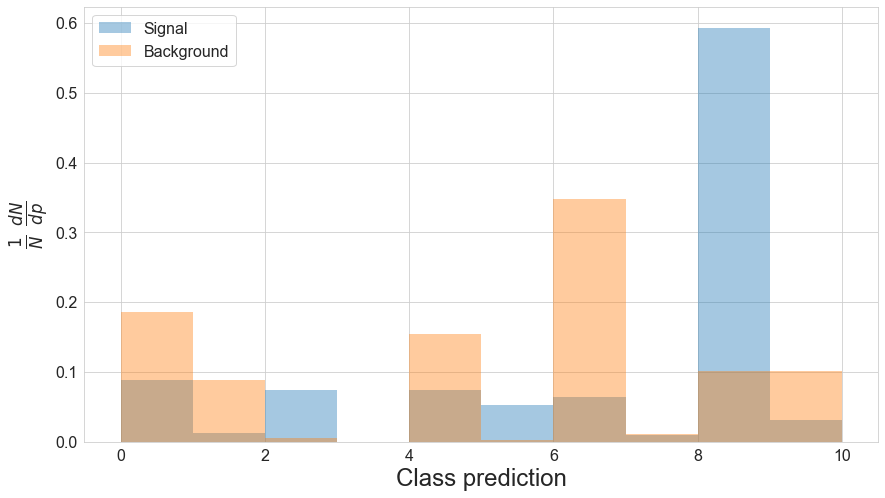

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [7]:
nll_inf = compute_nll(model_inf, True)

/Users/giles/anaconda3/envs/rise/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/rise/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


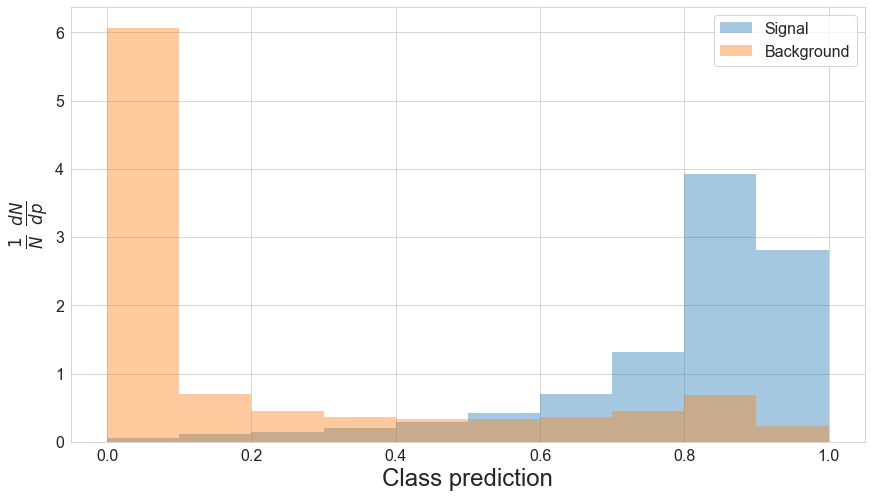

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [8]:
nll_bce = compute_nll(model_bce, False)

# Comparison
After computing the predictions on the test data and evaluating the profile likelihood (code skipped, but present in notebook), we can compare the sensitivity to the signal.

Both DNNs predict the same signal strength, however INFERNO is much more precise due to being aware of the systematics that affect the data.

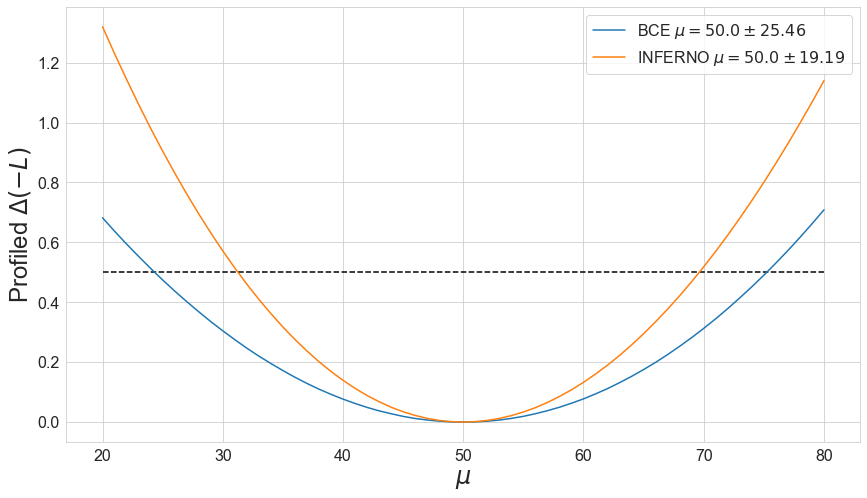

[25.45555503988841, 19.18651108206283]

In [9]:
plot_likelihood({'BCE':nll_bce, 'INFERNO':nll_inf}, mu_scan)

# Summary

- PyTorch INFERNO provides a starting point for applying INFERNO to your own work
    - is a pip installable package (`pip install pytorch_inferno`)
- Due to the task-specific nature of the concrete implementations, the user will always have to inherit and build there own classes
    - Not covered is an approximation of INFERNO, that could be more generalisable to work directly on systematic datasets
- The code also demonstrates how INFERNO can be potentially "dropped-in" to other frameworks with callback systems
- Other implementations:
    - Tensorflow 1, Pablo de Casto: https://github.com/pablodecm/paper-inferno
    - Tensorflow 2, Lukas Layer: https://github.com/llayer/inferno